In [1]:
from plugins import plot_data

In [2]:
%%capture
%load_ext jupyter_probcomp.magics
%matplotlib inline

In [3]:
%ripl --seed 2 --plugins plugins.py

Set seed of a new VentureScript RIPL to 2.00.
Loading plugin: plugins.py


In [4]:
%%venturescript
// MODEL
assume alpha ~ gamma(1.0, 1.0) #hypers:0 ;
assume assign = make_crp(alpha) ;
assume z = mem((row) ~> { assign() #cluster_assignment:row });
assume V = mem((col) ~> { gamma(1.0, 1.0) #hypers:1});
assume component = mem((z, col) ~> {make_nig_normal(0.0, V(1), 1.0, 1.0)});
assume obs_func = mem((row) ~> {component(z(atom(row)), 1)() #component:row });                     
// Load synthetic data
define training_data = load_csv(str_concat(get_path(), "/training_data.csv"));
define test_data = load_csv(str_concat(get_path(), "/test_data.csv"));

In [5]:
training_data        = %venturescript training_data
test_data            = %venturescript test_data

In [6]:
run plugins.py

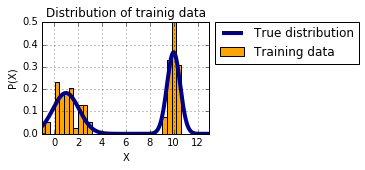

In [7]:
fig, ax = plot_data(training_data, 'Training data', title='Distribution of trainig data')

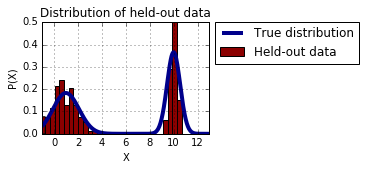

In [8]:
fig, ax = plot_data(test_data, 'Held-out data', title='Distribution of held-out data', color='darkred')

In [9]:
%%venturescript
// OBSERVATIONS
for_each(
    arange(size(training_data)),
    (i) -> {
        observe obs_func($i) = training_data[i]      
    }
);

In [10]:
%%venturescript
// INFERENCE
define single_site_mh = () -> {
    mh(default, one, 1)    
};

define resimulation_mh = () -> {
    mh(default, all, 1)    
};

define gibbs_with_mh2 = () -> {
    gibbs(quote(cluster_assignment), one, 1);
    mh(quote(hypers), one, 1)
};

define gibbs_with_slice = () -> {
    gibbs(quote(cluster_assignment), one, 1);
    slice(quote(hypers), one, 0.01, 10, 1)
};
define gibbs_pass = () -> {
    for_each(arange(size(training_data)),
        (x) -> {
            gibbs(quote(cluster_assignment), atom(x), 1)
        }
    )
};
define sequential_monte_carlo_slice_gibbs = () -> {
    for_each(
    arange(50),
    (i) -> {
        observe obs_func($i) = training_data[i]      
    }
    );
    //slice(quote(hypers), one, 0.01, 1000, 1);
    repeat(200, gibbs_with_slice());
    for_each(
        arange(50, size(training_data)),
        (i) -> {
            observe obs_func($i) = training_data[i]      
        }
    );
    gibbs_pass();
    
};

In [11]:
%%venturescript
define prior_samples = mapv(
    (i) -> {run(sample(component(z(atom($i)), 1)()))},
    arange(size(training_data), size(training_data) + 100)
);

In [12]:
prior_samples = %venturescript prior_samples

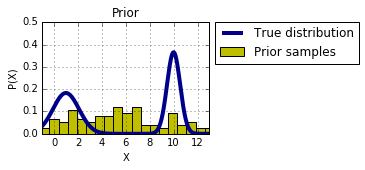

In [13]:
fig, ax = plot_data(prior_samples, 'Prior samples', title='Prior', color='y')

In [14]:
%%timeit -r1 -n1
%%venturescript
mh(default, one, 5000)

1 loop, best of 1: 14.2 s per loop


In [15]:
%%venturescript
define posterior_samples = mapv(
    (i) -> {run(sample(component(z(atom($i)), 1)()))},
    arange(size(training_data), size(training_data) + 100)
);

In [16]:
posterior_samples = %venturescript posterior_samples

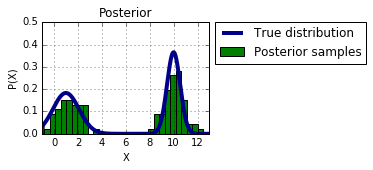

In [17]:
fig, ax = plot_data(posterior_samples, 'Posterior samples', title='Posterior', color='g')

### Trace rendering for paper

In [18]:
%%venturescript
define posterior_ssmh = mapv(
    (i) -> {run(sample(component(z(atom($i)), 1)()))},
    arange(size(training_data), size(training_data) + 10000)
);

In [19]:
post_ssmh = %venturescript posterior_ssmh

In [20]:
%%timeit -r1 -n1
%%venturescript
reset_to_prior;
mh(default, all, 50)

1 loop, best of 1: 17 s per loop


In [21]:
%%venturescript
define posterior_resim = mapv(
    (i) -> {run(sample(component(z(atom($i)), 1)()))},
    arange(size(training_data), size(training_data) + 10000)
);

In [22]:
post_resim = %venturescript posterior_resim

In [23]:
LS = '-'
LW = 3

In [24]:
def plot_traces(data, label, title='', color='orange'):
    data_to_render_curve = np.loadtxt("data_to_render_curve.csv")
    fig, ax = plt.subplots()
    ax.hist(data, normed=True, color=color, label=label, bins=30);
    pd.DataFrame({'True distribution': data_to_render_curve}).plot(
    kind='kde', ax=ax, linewidth=LW, color='black', linestyle=LS
    )
    outside={'loc': 'upper left',  'bbox_to_anchor':(1, 1.055)}
    ax.legend(**outside)
    ax.grid(True)
    ax.set_xlabel('X')
    ax.set_ylabel('P(X)')
    fig.set_size_inches(3, 2)
    ax.set_title(title)
    ax.set_xlim(-1, 13)
    ax.set_ylim(0, 0.5)
    return fig, ax

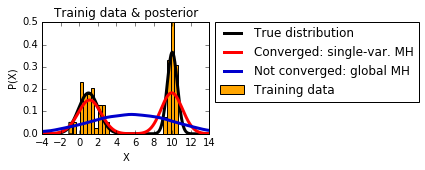

In [25]:
fig, ax = plot_traces(training_data, 'Training data', title='Trainig data & posterior')
ax.set_xlim(-4, 14)
ax.set_ylim(0, 0.5);
pd.DataFrame({'Converged: single-var. MH': post_ssmh}).plot(kind='kde', ax=ax, linewidth=LW, color='red', linestyle=LS)
pd.DataFrame({'Not converged: global MH': post_resim}).plot(kind='kde', ax=ax, linewidth=LW, color='mediumblue', linestyle=LS)
outside={'loc': 'upper left',  'bbox_to_anchor':(1, 1.055)}
ax.legend(**outside)
fig.set_size_inches(3, 2)
ax.set_ylabel('P(X)')